In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import math
import numpy.random as random
from PIL import Image
from skimage.io import imread, imsave

from sklearn.model_selection import cross_validate, train_test_split
from keras.utils import np_utils
from helpers import *

import tensorflow as tf
import keras.models as models
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, LeakyReLU
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adamax, Adam, SGD
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    y_true_am = K.argmax(y_true, axis=1)
    y_pred_am = K.argmax(y_pred, axis=1)
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives)
        return recall

    def precision(y_true, y_pred):
        
        
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives)
        return precision
    
    precision = precision(y_true_am, y_pred_am)
    recall = recall(y_true_am, y_pred_am)
    return 2*((precision*recall)/(precision+recall))

In [3]:
def random_crop(img, gt_img, patch=16, window=72, seed=1):
    padding = (window-patch)//2
    img = np.lib.pad(img, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    gt_img = np.lib.pad(gt_img, ((padding, padding), (padding, padding), (0,0)), 'reflect')
            
    center = np.random.randint(window//2, img.shape[0] - window//2, 2)
    
    img_crop = img[center[0]-window//2:center[0]+window//2, center[1]-window//2:center[1]+window//2]
    gt_crop = gt_img[center[0]-patch//2:center[0]+patch//2, center[1]-patch//2:center[1]+patch//2]
    
    return img_crop, one_hot_gt(gt_crop)

def generate_train(num_batches, imgs, gt_imgs, patch=16, window=72, augment=False, seed=1):
    while 1:
        batch_x = []
        batch_y = []
        for i in range(num_batches):
            idx = random.choice(imgs.shape[0])
            train_x, train_y = random_crop(imgs[idx], gt_imgs[idx], patch, window, seed)
#             if random.choice(3) == 0:
#                 while train_y[1] != 1:
#                     train_x, train_y = random_crop(imgs[idx], gt_imgs[idx], patch, window, seed)
            if augment:
                if random.choice(2):
                    img_crop = np.flipud(train_x)
                if random.choice(2):
                    img_crop = np.fliplr(train_x)
                rot = np.random.choice(4)
                img_crop = np.rot90(train_x, rot)
                
            batch_x.append(train_x)
            batch_y.append(train_y)
        yield(np.array(batch_x), np.array(batch_y))
        
def generate_test(num_batches, imgs, gt_imgs, patch=16, window=72, augment=False, seed=1):
    imgs_cropped = []
    for img in imgs:
        imgs_cropped += crop_img(img, patch, window)
    gt_imgs_cropped = crop_and_one_hot(gt_imgs, patch)
    while 1:
        batch_x = []
        batch_y = []
        for i in range(num_batches):
            idx = random.choice(len(imgs_cropped))
            test_x = imgs_cropped[idx]
            test_y = gt_imgs_cropped[idx]
#             if random.choice(3) == 0:
#                 while test_y[1] != 1:
#                     idx = random.choice(len(imgs_cropped))
#                     test_x = imgs_cropped[idx]
#                     test_y = gt_imgs_cropped[idx]
            if augment:
                if random.choice(2):
                    img_crop = np.flipud(test_x)
                if random.choice(2):
                    img_crop = np.fliplr(test_x)
                rot = np.random.choice(4)
                img_crop = np.rot90(test_x, rot)
            batch_x.append(test_x)
            batch_y.append(test_y)
        yield(np.array(batch_x), np.array(batch_y))

In [4]:
from sklearn.utils import class_weight
from keras.regularizers import l2

class CnnModel:
    
    def __init__(self, **args):
        pass
    def initialize_model(self, window=72):
        #model 
        self.model = models.Sequential()
        self.model.add(Conv2D(64, 5, padding='same', activation='relu', input_shape=(window,window,3), kernel_initializer='truncated_normal'))
        self.model.add(BatchNormalization())
        # model.add(LeakyReLU(alpha=0.1))
        # model.add(Conv2D(64, 3, padding='same'))
        # model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        # model.add(Dropout(0.25))
        # model.add(Conv2D(128, 3, padding='same', activation='tanh'))
        self.model.add(Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='truncated_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='truncated_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='truncated_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        # model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(128, kernel_initializer='truncated_normal', activation='relu'))
        # model.add(LeakyReLU(alpha=0.1))
        # model.add(Dense(16, activation='relu'))
        # model.add(Dropout(0.5))
        self.model.add(Dense(2,kernel_initializer='truncated_normal', activation='softmax'))
    
    def fit(self, imgs, gt_imgs, patch=16, window=72, num_batches=128, augment=False,
            steps_per_epoch=64, epochs=5, validation_steps=32, seed=42):
        self.initialize_model(window)
        def generate_train(num_batches, imgs, gt_imgs, patch=16, window=72, augment=False, seed=1):
            while 1:
                batch_x = []
                batch_y = []
                for i in range(num_batches):
                    idx = random.choice(imgs.shape[0])
                    train_x, train_y = random_crop(imgs[idx], gt_imgs[idx], patch, window, seed)
#                     if random.choice(10) == 0:
#                         while train_y[1] != 1:
#                             train_x, train_y = random_crop(imgs[idx], gt_imgs[idx], patch, window, seed)
                    if augment:
                        if random.choice(2):
                            img_crop = np.flipud(train_x)
                        if random.choice(2):
                            img_crop = np.fliplr(train_x)
                        rot = np.random.choice(4)
                        img_crop = np.rot90(train_x, rot)

                    batch_x.append(train_x)
                    batch_y.append(train_y)
                yield(np.array(batch_x), np.array(batch_y))
        
        def generate_test(num_batches, imgs, gt_imgs, patch=16, window=72, augment=False, seed=1):
            imgs_cropped = []
            for img in imgs:
                imgs_cropped += crop_img(img, patch, window)
            gt_imgs_cropped = crop_and_one_hot(gt_imgs, patch)
            while 1:
                batch_x = []
                batch_y = []
                for i in range(num_batches):
                    idx = random.choice(len(imgs_cropped))
                    test_x = imgs_cropped[idx]
                    test_y = gt_imgs_cropped[idx]
#                     if random.choice(10) == 0:
#                         while test_y[1] != 1:
#                             idx = random.choice(len(imgs_cropped))
#                             test_x = imgs_cropped[idx]
#                             test_y = gt_imgs_cropped[idx]
                    if augment:
                        if random.choice(2):
                            img_crop = np.flipud(test_x)
                        if random.choice(2):
                            img_crop = np.fliplr(test_x)
                        rot = np.random.choice(4)
                        img_crop = np.rot90(test_x, rot)
                    batch_x.append(test_x)
                    batch_y.append(test_y)
                yield(np.array(batch_x), np.array(batch_y))
                
#         X_train, X_test, y_train, y_test = train_test_split(imgs, gt_imgs, test_size=0.1, random_state=seed)
#         train_generator = generate_train(num_batches, X_train, y_train, patch=patch, window=window,
#                                          augment=augment, seed=seed)
        train_generator = generate_train(num_batches, imgs, gt_imgs, patch=patch, window=window,
                                         augment=augment, seed=seed)
#         X_test = crop_imgs(X_test, patch, window)
#         y_test = crop_and_one_hot(y_test, patch)
        cw = class_weight.compute_class_weight('balanced', [0,1], np.argmax(crop_and_one_hot(gt_imgs, 16), axis=1))
        cw = dict(enumerate(cw))
        def softmax_categorical_crossentropy(y_true, y_pred):
            return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

        self.model.compile(loss=softmax_categorical_crossentropy, optimizer='adam', metrics=['accuracy', f1])
        self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                                 class_weight=cw)#, validation_data=(X_test, y_test))
    
    def predict(self, imgs):
        return self.model.predict(imgs)
    
    def get_params(self, deep=True):
        return {'x': None}
    
    def set_params(self, **params):
        pass

In [6]:
from sklearn.metrics import f1_score

imgs, gt_imgs = load_training('training')

def scoring_cnn(cnnModel, imgs, gt_imgs):
    y_pred = np.argmax(cnnModel.predict(crop_imgs(imgs, 16, 72)), axis=1)
    
    y_true = np.argmax(crop_and_one_hot(gt_imgs, 16), axis=1)
    return f1_score(y_true, y_pred)
cnnModel = CnnModel()

from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(cnnModel, imgs, gt_imgs, scoring=scoring_cnn, cv=5, fit_params={'epochs' : 10})
print("The cnn model scored %.3f ± %.3f as f1-score"%(cv_score.mean(), cv_score.std()))

Epoch 1/10
64/64 [==============================] - 26s 409ms/step - loss: 0.5773 - acc: 0.7140 - f1: nan
Epoch 2/10
64/64 [==============================] - 25s 390ms/step - loss: 0.5509 - acc: 0.7406 - f1: 0.6117
Epoch 3/10
64/64 [==============================] - 25s 389ms/step - loss: 0.5076 - acc: 0.7921 - f1: 0.6714
Epoch 4/10
64/64 [==============================] - 25s 390ms/step - loss: 0.4639 - acc: 0.8335 - f1: 0.7330
Epoch 5/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4464 - acc: 0.8483 - f1: 0.7456
Epoch 6/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4428 - acc: 0.8666 - f1: 0.7745
Epoch 7/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4359 - acc: 0.8612 - f1: 0.7712
Epoch 8/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4229 - acc: 0.8767 - f1: 0.7937
Epoch 9/10
64/64 [==============================] - 25s 394ms/step - loss: 0.4294 - acc: 0.8771 - f1: 0.7931
Epoch 10/10
64/64 [===

/home/raph/.conda/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/10
64/64 [==============================] - 26s 409ms/step - loss: 0.6004 - acc: 0.6851 - f1: nan
Epoch 2/10
64/64 [==============================] - 25s 393ms/step - loss: 0.5140 - acc: 0.7799 - f1: 0.6488
Epoch 3/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4665 - acc: 0.8279 - f1: 0.7134
Epoch 4/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4500 - acc: 0.8473 - f1: 0.7397
Epoch 5/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4476 - acc: 0.8523 - f1: 0.7544
Epoch 6/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4493 - acc: 0.8495 - f1: 0.7515
Epoch 7/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4353 - acc: 0.8652 - f1: 0.7599
Epoch 8/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4324 - acc: 0.8745 - f1: 0.7806
Epoch 9/10
64/64 [==============================] - 25s 393ms/step - loss: 0.4287 - acc: 0.8711 - f1: 0.7757
Epoch 10/10
64/64 [===

In [48]:
cnnModel = CnnModel()
cnnModel.fit(imgs, gt_imgs, epochs=20)

Epoch 1/35
64/64 [==============================] - 36s 561ms/step - loss: 0.5873 - acc: 0.6873 - f1: 0.5609 - val_loss: 0.9111 - val_acc: 0.3053 - val_f1: nan
Epoch 2/35
64/64 [==============================] - 32s 503ms/step - loss: 0.4965 - acc: 0.7915 - f1: 0.6626 - val_loss: 1.0563 - val_acc: 0.2563 - val_f1: nan
Epoch 3/35
64/64 [==============================] - 32s 503ms/step - loss: 0.4554 - acc: 0.8442 - f1: 0.7365 - val_loss: 0.7575 - val_acc: 0.4835 - val_f1: nan
Epoch 4/35
64/64 [==============================] - 32s 503ms/step - loss: 0.4558 - acc: 0.8499 - f1: 0.7559 - val_loss: 0.7753 - val_acc: 0.4805 - val_f1: nan
Epoch 5/35
64/64 [==============================] - 32s 503ms/step - loss: 0.4475 - acc: 0.8517 - f1: 0.7475 - val_loss: 0.5704 - val_acc: 0.7440 - val_f1: nan
Epoch 6/35
64/64 [==============================] - 32s 503ms/step - loss: 0.4352 - acc: 0.8715 - f1: 0.7854 - val_loss: 0.5706 - val_acc: 0.7437 - val_f1: nan
Epoch 7/35
64/64 [======================

KeyboardInterrupt: 

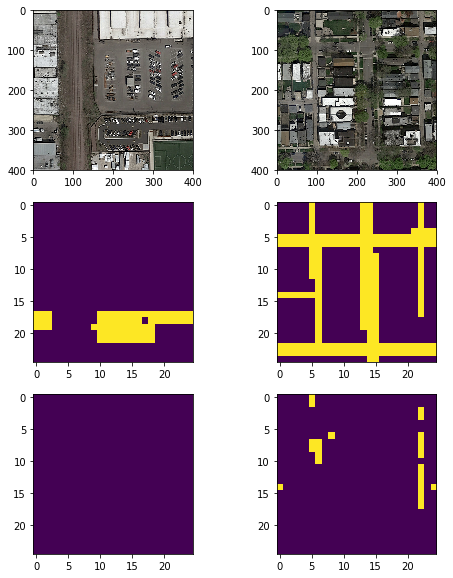

In [44]:
plt.figure(figsize=(8, 10))
plt.subplot(321)
plt.imshow(imgs[0])
plt.subplot(323)
plt.imshow(np.argmax(crop_and_one_hot(gt_imgs[:1]), axis=1).reshape(25,25))
plt.subplot(325)
plt.imshow(np.argmax(cnnModel.predict(np.array([crop.tolist() for crop in crop_img(imgs[0], 16, 72)])), axis=1).reshape(25,25))
plt.subplot(322)
plt.imshow(imgs[1])
plt.subplot(324)
plt.imshow(np.argmax(crop_and_one_hot(gt_imgs[1:2]), axis=1).reshape(25,25))
plt.subplot(326)
plt.imshow(np.argmax(cnnModel.predict(np.array([crop.tolist() for crop in crop_img(imgs[1], 16, 72)])), axis=1).reshape(25,25))

In [30]:
cnnModel.fit(imgs, gt_imgs, epochs=10)

Epoch 1/10
64/64 [==============================] - 26s 400ms/step - loss: 0.8002 - acc: 0.7466 - f1: nan - val_loss: 0.5716 - val_acc: 0.7417 - val_f1: nan
Epoch 2/10
64/64 [==============================] - 25s 384ms/step - loss: 0.7848 - acc: 0.7532 - f1: nan - val_loss: 0.5840 - val_acc: 0.7292 - val_f1: nan
Epoch 3/10
64/64 [==============================] - 25s 385ms/step - loss: 0.8056 - acc: 0.7443 - f1: nan - val_loss: 0.5811 - val_acc: 0.7322 - val_f1: nan
Epoch 4/10
64/64 [==============================] - 25s 385ms/step - loss: 0.8067 - acc: 0.7438 - f1: nan - val_loss: 0.5637 - val_acc: 0.7495 - val_f1: nan
Epoch 5/10
63/64 [============================>.] - ETA: 0s - loss: 0.8109 - acc: 0.7419 - f1: nan

KeyboardInterrupt: 

In [8]:
seed = 42
window = 72
patch = 16
num_batches = 128

X_train, X_test, y_train, y_test = train_test_split(imgs, gt_imgs, test_size=0.2, random_state=seed)

train_generator = generate_train(num_batches, X_train, y_train, patch=patch, window=window, seed=seed)
# train_generator = generate_minibatch(num_batches, X_train, y_train, window, patch)
test_generator = generate_test(num_batches, X_test, y_test, patch=patch, window=window, seed=seed)

#model 
model = models.Sequential()
model.add(Conv2D(64, 5, padding='same', activation='relu', input_shape=(window,window,3), kernel_initializer='truncated_normal'))
model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# model.add(Conv2D(64, 3, padding='same'))
# model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, 3, padding='same', activation='tanh'))
model.add(Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='truncated_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='truncated_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='truncated_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(256, 3, padding='same', activation='tanh'))
# model.add(Conv2D(256, 3, padding='same', activation='tanh'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_initializer='truncated_normal', activation='relu'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2,kernel_initializer='truncated_normal', activation='softmax'))

def softmax_categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

model.compile(loss=softmax_categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy', f1])
model.fit_generator(train_generator, steps_per_epoch=32, epochs=5, class_weight=class_weight, validation_data=test_generator, validation_steps=32)

Epoch 1/5
32/32 [==============================] - 21s 668ms/step - loss: 0.6313 - acc: 0.6665 - f1: 0.5020 - val_loss: 1.0223 - val_acc: 0.2854 - val_f1: 0.4241
Epoch 2/5
32/32 [==============================] - 17s 528ms/step - loss: 0.5537 - acc: 0.7205 - f1: 0.6045 - val_loss: 1.0625 - val_acc: 0.2505 - val_f1: 0.3988
Epoch 3/5
32/32 [==============================] - 17s 533ms/step - loss: 0.5154 - acc: 0.7644 - f1: 0.6448 - val_loss: 1.0467 - val_acc: 0.2664 - val_f1: 0.4191
Epoch 4/5
32/32 [==============================] - 17s 534ms/step - loss: 0.4875 - acc: 0.7988 - f1: 0.6797 - val_loss: 1.0642 - val_acc: 0.2490 - val_f1: 0.3976
Epoch 5/5
32/32 [==============================] - 17s 534ms/step - loss: 0.4653 - acc: 0.8345 - f1: 0.7404 - val_loss: 0.5805 - val_acc: 0.7327 - val_f1: nan


In [22]:
model.fit_generator(train_generator, steps_per_epoch=64, epochs=10, class_weight=class_weight, validation_data=test_generator, validation_steps=32)

Epoch 1/10
64/64 [==============================] - 30s 468ms/step - loss: 0.3689 - acc: 0.9410 - f1: 0.8927 - val_loss: 0.5120 - val_acc: 0.7944 - val_f1: 0.4630
Epoch 2/10
64/64 [==============================] - 29s 460ms/step - loss: 0.3698 - acc: 0.9395 - f1: 0.8903 - val_loss: 0.4230 - val_acc: 0.8865 - val_f1: 0.7946
Epoch 3/10
64/64 [==============================] - 29s 458ms/step - loss: 0.3641 - acc: 0.9463 - f1: 0.9005 - val_loss: 0.4404 - val_acc: 0.8662 - val_f1: 0.6912
Epoch 4/10
64/64 [==============================] - 30s 464ms/step - loss: 0.3633 - acc: 0.9463 - f1: 0.9014 - val_loss: 0.4391 - val_acc: 0.8694 - val_f1: 0.7517
Epoch 5/10
64/64 [==============================] - 30s 466ms/step - loss: 0.3637 - acc: 0.9458 - f1: 0.8995 - val_loss: 0.4084 - val_acc: 0.9014 - val_f1: 0.7887
Epoch 6/10
64/64 [==============================] - 30s 466ms/step - loss: 0.3705 - acc: 0.9414 - f1: 0.8918 - val_loss: 0.4849 - val_acc: 0.8242 - val_f1: 0.5129
Epoch 7/10
64/64 [====

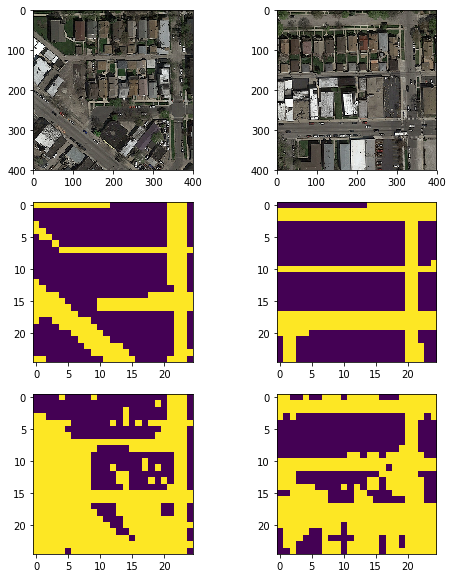

In [21]:
plt.figure(figsize=(8, 10))
plt.subplot(321)
plt.imshow(X_test[0])
plt.subplot(323)
plt.imshow(np.argmax(crop_and_one_hot(y_test[:1]), axis=1).reshape(25,25))
plt.subplot(325)
plt.imshow(np.argmax(model.predict(np.array([crop.tolist() for crop in crop_img(X_test[0], 16, 72)])), axis=1).reshape(25,25))
plt.subplot(322)
plt.imshow(X_train[0])
plt.subplot(324)
plt.imshow(np.argmax(crop_and_one_hot(y_train[:1]), axis=1).reshape(25,25))
plt.subplot(326)
plt.imshow(np.argmax(model.predict(np.array([crop.tolist() for crop in crop_img(X_train[0], 16, 72)])), axis=1).reshape(25,25))